### MSc Computer Science, Data Science @UniPD
### Optimization Methods for Data Science
---

# Packages

In [454]:
from os.path import isdir
from os import mkdir

env = 'pc'  # 'pc', 'colab'
git_download_path = 'https://raw.githubusercontent.com/PashaIanko/Semi-Supervised-Labelling/accuracy_track/'
experiment = 'Exp5/'

save_dir = ''
if env == 'pc':
    save_dir = f'C:/Users/79137/Pasha/2. UNIPD/Semester 2/Optimization for Data Science/Homeworks/HW 1/Semi-Supervised-Labelling/'
elif env == 'colab':
    save_dir = f'/content/drive/MyDrive/UNIPD/ODS/HW1/'

In [455]:
%%capture

def download_files(url_dict):
    for file, url in url_dict.items():
        !wget -O {file} {url} {file}

if env == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')

    files = [
           'BCGDSolver.py',
           'DataProperties.py',
           'GradientDescentSolver.py',
           'GradientSolver.py',
           'Utils.py'  
    ]

    url_dict = {file: git_download_path + file for file in files}
    download_files(url_dict)

# Saving directory

In [456]:
full_dir = f'{save_dir}{experiment}'
assert(isdir(save_dir))

if not isdir(full_dir):
    mkdir(full_dir)

assert(isdir(full_dir))

In [457]:
from sklearn.datasets import make_blobs
import numpy as np

from sklearn import datasets
from sklearn.metrics import accuracy_score
import pandas as pd
import timeit

# Plotting
import matplotlib.pyplot as plt

In [458]:
import Utils
import GradientSolver
import GradientDescentSolver
import DataProperties
import BCGDSolver
import importlib

def reload_all(modules_list):
    for module in modules_list:
        importlib.reload(module)

reload_all(
    [
        Utils,
        GradientSolver,
        GradientDescentSolver,
        DataProperties,
        BCGDSolver
    ]
)

from Utils import *
from GradientSolver import GradientSolver
from GradientDescentSolver import GradientDescentSolver
from DataProperties import DataProperties
from BCGDSolver import BCGDSolver

# Data preparation

In [459]:
# Fix states
sklearn_random_state = 42
numpy_seed = 42

np.random.seed(numpy_seed)

In [460]:
# %%timeit
X, Y = make_blobs(
    n_samples = DataProperties.n_samples,
    centers = DataProperties.n_clusters,
    n_features = DataProperties.n_dims,
    random_state = sklearn_random_state,
    cluster_std = 1.5
)


def euclidian_similarity(Xi, Xj):
    return 1 / (norm(Xi - Xj) + 0.001)

In [461]:
# %%timeit

# Old inefficient weights calculation
# weights = calc_weight_matrix(X, weight_func = None)

from sklearn.metrics import pairwise_distances

weights = pairwise_distances(X, metric = 'euclidean')
weights = 1 / (weights + 0.001)
assert(weights.shape == (DataProperties.n_samples, DataProperties.n_samples))

Data shape: X: (500, 2), Y: (500,)


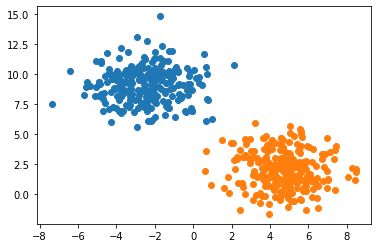

In [462]:
Y = Y.astype('float64')
clusters = np.unique(Y)

print(f'Data shape: X: {X.shape}, Y: {Y.shape}')
plot_clusters(X, Y)

## Unlabel subset and visualize

Found 250 instances of object 0.0
We have to delabel 237 instances
Found 250 instances of object 1.0
We have to delabel 237 instances

    We have 474 unlabeled data
    Out of 500
    


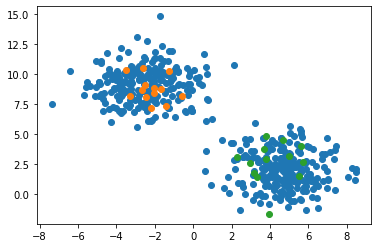

In [463]:
Y_delabeled = delabel_data(
    Y,
    labeled_percent = DataProperties.labeled_percentage,
    delabel_value = DataProperties.unlabeled
)

print(
    f'''
    We have {len(Y_delabeled[Y_delabeled == DataProperties.unlabeled])} unlabeled data
    Out of {len(Y_delabeled)}
    '''
)

plot_clusters(X, Y_delabeled)

- Up to now, we have the clustered data, saved correct labelling (Y) and delabelled data (Y_delabelled)
- For the unlabelled y variables, the loss function depends on the (y_1, ..., y_U) unlabeled parameters. Each of the
parameters is independent on others, and can be 0 or 1 (for **binary clustering problem**). This is why we will be searching
for **optimal solution in the R^(U)** space, which yields minimum to the **loss function**

In [464]:
import collections
class_stats = collections.Counter(Y_delabeled)
assert(len(class_stats.keys()) == 3)  # 2 labeled classes and 1 unlabeled
print(class_stats)

Counter({-1000000.0: 474, 0.0: 13, 1.0: 13})


# Gradient descent

In [465]:
solver = GradientDescentSolver(
    similarity_func = None, # euclidian_similarity,
    lr_strategy = 'lr_constant',  # search for alpha_k
    learning_rate = 0.001
)

In [466]:
# Y_preds_GD = solver.solve(
#     X, 
#     Y_delabeled,
#     Y_true = Y,
#     iter_limit = 30,
#     delta_percent_limit = 0.20,  # when dLoss / dLoss prev < 0.02
#     delta_loss_limit = 0.0, # dont use
#     stop_loss = 0.0,  # dont use
#     weight_matrix = weights
# )

Accuracy: 1.0


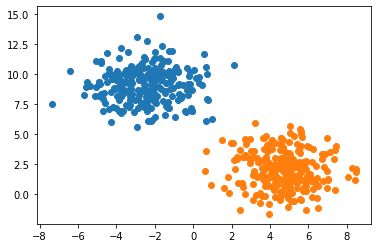

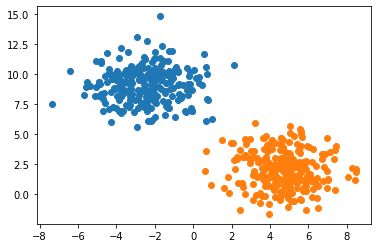

In [467]:
plot_clusters(X, Y)
plot_clusters(X, Y_preds_GD)
print(f'Accuracy: {accuracy_score(Y, Y_preds_GD)}')

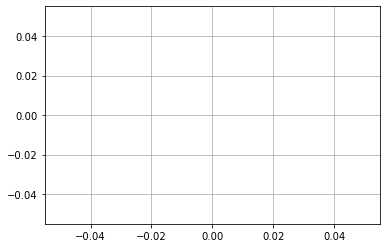

In [468]:
plt.plot(solver.losses, marker = 'o')
plt.grid()

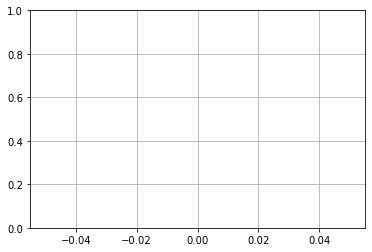

In [469]:
plt.plot(solver.accuracies, marker = 'o')
plt.ylim([0, 1])
plt.grid()

# Block coordinates gradient descent (randomized)

## BCGD random permutations

In [470]:
random_solver = BCGDSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.0001,
    similarity_func = None,

    bcgd_strategy = 'random permutation',
)

In [477]:
Y_preds_BCGD_permutation = random_solver.solve(
    X, 
    Y_delabeled, 
    Y_true = Y,
    iter_limit = 20,
    delta_percent_limit = 0.05,  # when dLoss / dLoss prev
    delta_loss_limit = 0.0,
    stop_loss= 0.0,
    weight_matrix = weights
)

Iteration: 0, Loss: 1107.5101523963954, Delta: 1107.5101523963954
Iteration: 1, Loss: 1104.904709584464, Delta: 2.6054428119314252
Iteration: 2, Loss: 1102.3830128917034, Delta: 2.5216966927605426
Iteration: 3, Loss: 1099.941630111697, Delta: 2.4413827800065064
Iteration: 4, Loss: 1097.577308709851, Delta: 2.3643214018459275
Iteration: 5, Loss: 1095.2869650782914, Delta: 2.290343631559608
Iteration: 6, Loss: 1093.0676876302728, Delta: 2.2192774480186017
Iteration: 7, Loss: 1090.9166789967528, Delta: 2.1510086335199503
Iteration: 8, Loss: 1088.831296188333, Delta: 2.0853828084198085
Iteration: 9, Loss: 1086.8090234221986, Delta: 2.0222727661343924
Iteration: 10, Loss: 1084.8474894457, Delta: 1.9615339764986857
Iteration: 11, Loss: 1082.9444098054007, Delta: 1.903079640299211
Iteration: 12, Loss: 1081.0976093820047, Delta: 1.8468004233959618
Iteration: 13, Loss: 1079.3050269320051, Delta: 1.7925824499995997
Iteration: 14, Loss: 1077.5646938828768, Delta: 1.7403330491283668
Iteration: 15,

Accuracy: 1.0


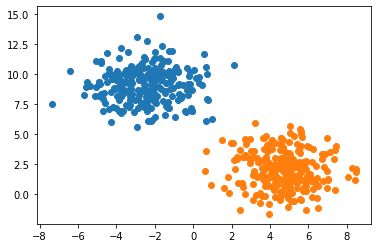

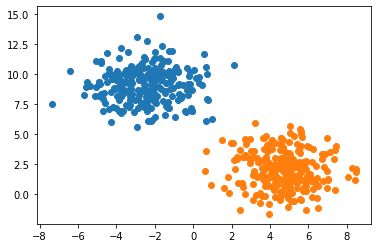

In [478]:
plot_clusters(X, Y)
plot_clusters(X, Y_preds_BCGD_permutation)
print(f'Accuracy: {accuracy_score(Y, Y_preds_BCGD_permutation)}')

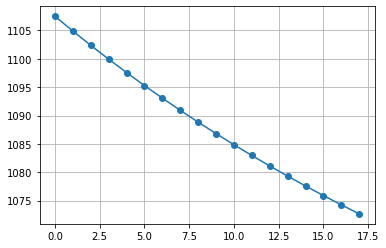

In [479]:
plt.plot(random_solver.losses, marker = 'o')
plt.grid()

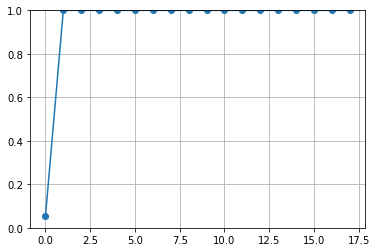

In [480]:
plt.plot(random_solver.accuracies, marker = 'o')
plt.ylim([0, 1])
plt.grid()

## BCGD random sampling

In [481]:
BCGD_RS_solver = BCGDSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.001,
    similarity_func = None,
    bcgd_strategy = 'random sampling'
)

In [485]:
Y_preds_BCGD_sampling = BCGD_RS_solver.solve(
    X = X, 
    Y = Y_delabeled,
    Y_true = Y,
    iter_limit = 10, #  * len(Y_delabeled[Y_delabeled == DataProperties.unlabeled]),
    delta_loss_limit = 0.0,
    delta_percent_limit = 0.00,  # when dLoss / dLoss prev
    stop_loss= 0,
    weight_matrix = weights
)

Iteration: 0, Loss: 1107.5101523963954, Delta: 1107.5101523963954
Iteration: 1, Loss: 1107.4571833652776, Delta: 0.05296903111775464
Iteration: 2, Loss: 1107.4449981640466, Delta: 0.012185201230977327
Iteration: 3, Loss: 1107.4366437351907, Delta: 0.008354428855909646
Iteration: 4, Loss: 1107.3886566798385, Delta: 0.04798705535222325
Iteration: 5, Loss: 1107.3684437433071, Delta: 0.020212936531379455
Iteration: 6, Loss: 1107.364836467967, Delta: 0.0036072753400731017
Iteration: 7, Loss: 1107.2943720711537, Delta: 0.0704643968133496
Iteration: 8, Loss: 1107.2462400365944, Delta: 0.04813203455933035
Iteration: 9, Loss: 1107.2112276120536, Delta: 0.03501242454080966


Accuracy: 0.538


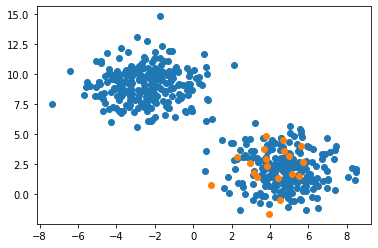

In [486]:
plot_clusters(
    X, Y_preds_BCGD_sampling
)
print(f'Accuracy: {accuracy_score(Y, Y_preds_BCGD_sampling)}')

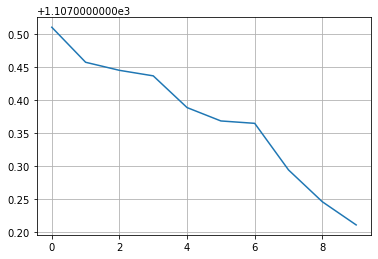

In [487]:
plt.plot(BCGD_RS_solver.losses)
plt.grid()

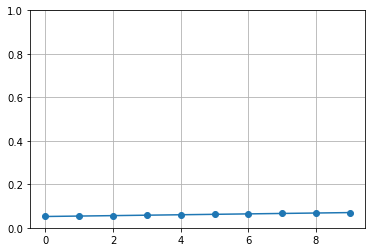

In [488]:
plt.plot(BCGD_RS_solver.accuracies, marker = 'o')
plt.ylim([0, 1])
plt.grid()

## BCGD cyclic

In [489]:
BCGD_cyclic_solver = BCGDSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.001,
    similarity_func = None,
    bcgd_strategy = 'cyclic'
)

In [493]:
Y_preds_BCGD_cyclic = BCGD_cyclic_solver.solve(
    X,
    Y_delabeled, 
    Y_true = Y,
    iter_limit = 15, 
    delta_percent_limit = 0.40,  # when dLoss / dLoss prev
    delta_loss_limit = 0.0001,
    stop_loss = 0,
    weight_matrix = weights
)

Iteration: 0, Loss: 1107.5101523963954, Delta: 1107.5101523963954
Iteration: 1, Loss: 1080.8441163316559, Delta: 26.6660360647395
Iteration: 2, Loss: 1062.3872348806692, Delta: 18.456881450986657
Iteration: 3, Loss: 1049.2067649379549, Delta: 13.180469942714353
Iteration: 4, Loss: 1039.5975724311488, Delta: 9.609192506806039
Iteration: 5, Loss: 1032.4933553150256, Delta: 7.104217116123209
Iteration: 6, Loss: 1027.188946249916, Delta: 5.304409065109667
Iteration: 7, Loss: 1023.1990425048089, Delta: 3.9899037451070853
Iteration: 8, Loss: 1020.1802516477686, Delta: 3.018790857040244
Iteration: 9, Loss: 1017.8848266002966, Delta: 2.2954250474720084
Iteration: 10, Loss: 1016.1315382097453, Delta: 1.7532883905513472
Iteration: 11, Loss: 1014.7864807765555, Delta: 1.3450574331897087
Iteration: 12, Loss: 1013.7499789643618, Delta: 1.0365018121937055
Iteration: 13, Loss: 1012.9474220953234, Delta: 0.8025568690384262
0.3035878770748794
Exit condition


Accuracy: 1.0


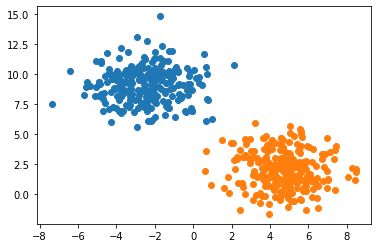

In [494]:
print(f'Accuracy: {accuracy_score(Y_preds_BCGD_cyclic, Y)}')
plot_clusters(
    X, Y_preds_BCGD_cyclic
)

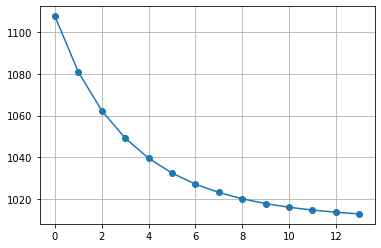

In [495]:
plt.plot(BCGD_cyclic_solver.losses, marker = 'o')
plt.grid()

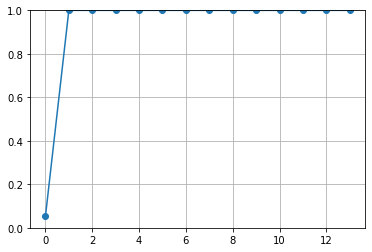

In [496]:
plt.plot(BCGD_cyclic_solver.accuracies, marker = 'o')
plt.ylim([0, 1])
plt.grid()

# Model comparison

We will compare models based on:
- Clustering metrics
- CPU time
- Number of iterations
- Loss curves
- Distance metrics

In [503]:
learning_rate_strategy = 'lr_constant'
simil_func = None  # No feature yet
lr = 0.00001

gd_solver = GradientDescentSolver(
    similarity_func = simil_func,
    lr_strategy = learning_rate_strategy,
    learning_rate = lr
)

bcgd_permut_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'random permutation',
)

bcgd_sampling_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'random sampling',
)

bcgd_cyclic_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'cyclic',
)

solvers = {
    'GD': gd_solver,
    'BCGD permutation': bcgd_permut_solver,
    'BCGD cyclic': bcgd_cyclic_solver,
    # 'BCGD sampling': bcgd_sampling_solver,
}

In [504]:
def compare_models(solvers_dict, X, Y_true, Y_delabeled, iters_limit, delta_percent_limit, delta_loss_limit, stop_loss, weights_matrix):
    predictions = {k:None for k in solvers_dict.keys()}
    losses = {k:None for k in solvers_dict.keys()}
    n_iterations = {k:None for k in solvers_dict.keys()}
    cpu_times_total = {k:None for k in solvers_dict.keys()}

    for model_name, model in solvers_dict.items():
        print(f'Fitting {model_name}')
        start = timeit.default_timer()
        Y_preds = model.solve(
            X,
            Y_delabeled,
            Y_true = Y_true,
            iter_limit = iters_limit,
            delta_percent_limit = delta_percent_limit,
            delta_loss_limit = delta_loss_limit,
            stop_loss= stop_loss,
            weight_matrix = weights_matrix
        )
        end = timeit.default_timer()
        predictions[model_name] = Y_preds
        losses[model_name] = model.losses
        n_iterations[model_name] = model.n_iterations
        cpu_times_total[model_name] = end - start
    

    return predictions, losses, n_iterations, cpu_times_total

In [506]:
iters_limit = 20
delta_loss_limit = 0.0001
stop_loss= 200  # 4000
delta_percent_limit = 0.01,  # when dLoss / dLoss prev


preds, losses, n_iters, cpu_times_total = compare_models(
        solvers,
        X,
        Y_delabeled = Y_delabeled,
        Y_true = Y,
        iters_limit = iters_limit,
        delta_percent_limit = delta_percent_limit,
        delta_loss_limit = delta_loss_limit,
        stop_loss = stop_loss,
        weights_matrix =  weights
    )

Fitting GD
Iteration: 0, Loss: 1107.5101523963954, delta loss: 1107.5101523963954
Iteration: 1, Loss: 1107.2507692703593, delta loss: -0.25938312603602753
Iteration: 2, Loss: 1106.9922220857486, delta loss: -0.2585471846107339
Iteration: 3, Loss: 1106.7345073765568, delta loss: -0.25771470919175954
0.0008351669999687756
Exit condition


Fitting BCGD permutation
Iteration: 0, Loss: 1107.5101523963954, Delta: 1107.5101523963954
Iteration: 1, Loss: 1107.250463114554, Delta: 0.25968928184147444
Iteration: 2, Loss: 1106.9916114865646, Delta: 0.2588516279893156
Iteration: 3, Loss: 1106.7335940375863, Delta: 0.2580174489783076
0.0008368784464621765
Exit condition
Fitting BCGD cyclic
Iteration: 0, Loss: 1107.5101523963954, Delta: 1107.5101523963954
Iteration: 1, Loss: 1107.2504631208042, Delta: 0.2596892755911995
Iteration: 2, Loss: 1106.991611502605, Delta: 0.2588516181990599
Iteration: 3, Loss: 1106.7335940673995, Delta: 0.25801743520560194
0.0008368824533096098
Exit condition


In [507]:
accuracies = {name: solver.accuracies for name, solver in solvers.items()}
cpu_times = {name: solver.cpu_times for name, solver in solvers.items()}

## Saving data

In [29]:
# iters_limit = 17
# delta_loss_limit = 0.0001
# stop_loss= 21000  # 4000

experiment_params = pd.DataFrame(
    {
        'iters_limit': [iters_limit],
        'd_loss_limit': [delta_loss_limit],
        'stop_loss': [stop_loss],
        'learning_rate': [lr],
        'n points': [DataProperties.n_samples]
    },
    # index = False
)

experiment_params.to_csv(full_dir + 'experiment_params.csv')
experiment_params.head()

,iters_limit,d_loss_limit,stop_loss,learning_rate,n points
0,5,0.0001,200,0.00001,10000


In [31]:
results = pd.DataFrame()

# fill losses
for model_name, loss in losses.items():
    new = pd.DataFrame({f'{model_name} loss': loss})
    results = pd.concat([results, new], axis = 1)
    # results[f'{model_name} loss'] = loss

for model_name, cpu_time in cpu_times.items():
    new = pd.DataFrame({f'{model_name} cpu': cpu_time})
    results = pd.concat([results, new], axis = 1)
    # results[f'{model_name} cpu'] = cpu_time

for model_name, acc in accuracies.items():
    new = pd.DataFrame({f'{model_name} acc': acc})
    results = pd.concat([results, new], axis = 1)


results.to_csv(full_dir + 'res.csv')
results.head()

,GD loss,GD cpu,GD acc
0,411902.742330,129.722159,0.0500
1,410322.923139,379.174083,0.9996
2,408824.237166,621.618385,0.9996
3,407401.915357,871.115131,0.9995
4,406051.531514,1114.261903,0.9995


,CPU total time,N iterations,Final accuracy,CPU total time_norm,N iterations_norm,Final accuracy_norm
GD,1230.347575,5,0.9995,1.0,1.0,1.0


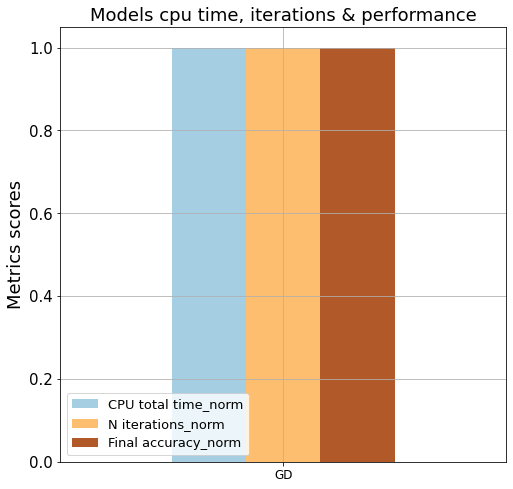

In [32]:
bar_metrics = pd.DataFrame.from_dict(cpu_times_total, orient='index', columns = ['CPU total time'])
bar_metrics['N iterations'] = n_iters.values()

final_accuracies = {name: acc[-1] for name, acc in accuracies.items()}
bar_metrics['Final accuracy'] = final_accuracies.values()



normalize_cols(bar_metrics)
cols_to_plot = [c for c in bar_metrics.columns if 'norm' in c]

plot_bar_metrics(bar_metrics.loc[:, cols_to_plot])
bar_metrics.to_csv(full_dir + 'metrics res.csv')

bar_metrics.head()

## Graphics

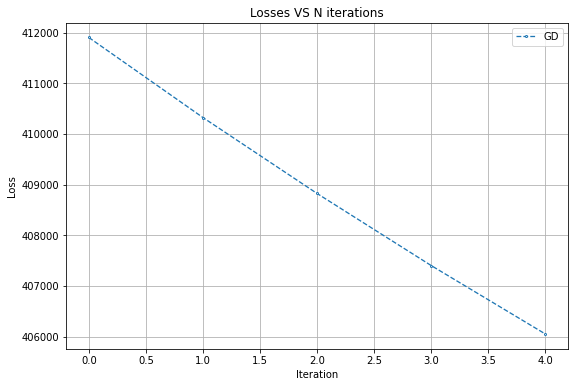

In [33]:
def plot_curves(curves_dict, title, y_label, figsize):
    _, ax = plt.subplots(figsize = figsize)

    for _, curve_res in curves_dict.items():
        ax.plot(
            curve_res,
            marker = 'o',
            linestyle = '--',
            linewidth = 1.3,
            markerfacecolor = 'white',
            markersize = 2
        )
    plt.legend(list(curves_dict.keys()))
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel(y_label)
    plt.grid()


# plot_curves({'Cyclic':losses['BCGD cyclic']}, 'Losses cyclic', y_label = 'Loss')
# plot_curves({'GD':losses['GD']}, 'Losses GD', y_label = 'Loss')
plot_curves(
    losses,
    'Losses VS N iterations', 
    y_label = 'Loss',
    figsize = (9, 6)
)

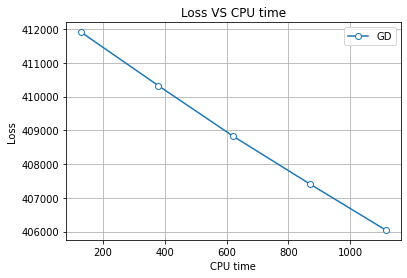

In [34]:
def plot_losses_vs_cpu(losses_, cpu_times_):
    assert(list(losses_.keys()) == list(cpu_times_.keys()))

    _, ax = plt.subplots()

    for model_name, loss in losses_.items():
        cpu_time = cpu_times_[model_name]

        ax.plot(
            cpu_time,
            loss,
            marker = 'o',
            markerfacecolor = 'white'
        )
    plt.xlabel('CPU time')
    plt.ylabel('Loss')
    plt.title('Loss VS CPU time')
    plt.legend(list(losses_.keys()))
    plt.grid()


plot_losses_vs_cpu(losses, cpu_times)

# Real dataset

In [ ]:
# df = pd.read_csv('Pokemon.csv')

In [ ]:
# df.head()

,number,name,type1,type2,total,hp,attack,defense,sp_attack,sp_defense,speed,generation,legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,Mega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,3,Gigantamax Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False


In [ ]:
# df.head()
# X_real = df.loc[:, ['total', 'sp_attack']].values
# Y_real = df['legendary'].astype('int').values


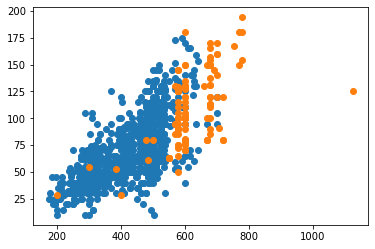

In [ ]:
# plot_clusters(
#     X_real,
#     Y_real
# )

In [ ]:
# Y_real_delabeled = delabel_data(
#     Y_real,
#     labeled_percent = 0.16, # DataProperties.labeled_percentage,
#     delabel_value = DataProperties.unlabeled
# )

Found 954 instances of object 0
We have to delabel 801 instances
Found 118 instances of object 1
We have to delabel 99 instances


In [ ]:
# wine=datasets.load_wine()

# #Conver to pandas dataframe
# data=pd.DataFrame(data=np.c_[wine['data'],wine['target']],columns=wine['feature_names']+['target'])

# data = data.loc[
#     (data['target'] == 1) | (data['target'] == 0),
#     ['od280/od315_of_diluted_wines', 'alcohol', 'target']
# ]

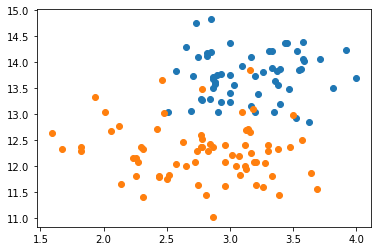

In [ ]:
# X_real = data.loc[
#     :,
#     ['od280/od315_of_diluted_wines', 'alcohol']
# ].values
# Y_real = data['target'].values

# plot_clusters(
#     X_real,
#     Y_real
# )

In [ ]:
# solver = GradientDescentSolver(
#     lr_strategy = 'lr_constant',
#     learning_rate = 0.0001,
#     similarity_func = None
# )

# Y_real_preds = solver.solve(
#     X_real,
#     Y_real_delabeled,
#     iter_limit=5,
#     delta_loss_limit = 0.003,
#     stop_loss = 20
# )

Iteration: 0, Loss: 24173.807351957803, delta loss: 24173.807351957803
Iteration: 1, Loss: 24173.807351957803, delta loss: 0.0
Iteration: 2, Loss: 24173.807351957803, delta loss: 0.0
Iteration: 3, Loss: 24173.807351957803, delta loss: 0.0
Iteration: 4, Loss: 24173.807351957803, delta loss: 0.0


